# An Introduction to ATA Capstone Binary classification using Linear Learner with MNIST
_**Making a Binary Prediction of Whether a user is a potential cheater**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the linear model](#Training-the-linear-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [241]:

# import the Python libraries we'll need, define IAM role and S3 bucket
import numpy as np # NumPy is the fundamental package for scientific computing with Python
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd # open source library providing high-performance, easy-to-use data structures, and data analysis tools for Python
import boto3
import re
from sagemaker import get_execution_role
import os
import io
import time
import json
import sagemaker.amazon.common as smac

role = get_execution_role()

bucket = 'us-west-2-itsmagic-highscores'
prefix = 'capstone'

### Data Prep

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [242]:
%%time
import urllib.request

# use panda framework to download data from S3
data_filename = 'mldemodata.csv'
data_source = 'https://us-west-2-itsmagic-highscores.s3-us-west-2.amazonaws.com/mldemodata.csv'

urllib.request.urlretrieve(data_source, data_filename)

# check data rows and columns
game_data = pd.read_csv(data_filename, delimiter=',')
print(game_data.shape)

(19, 3)
CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 106 ms


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

In [243]:
# see the first five rows of the data
game_data.head(7)

,Score,Classification,Fraud?
0,10001,1,True.
1,9999,0,False.
2,800,0,False.
3,30000,1,True.
4,50000,1,True.
5,80000,1,True.
6,700,0,False.


In [162]:
# rewrite the points in python to get a visualization of the data

# mypoints = array([[1,20001],[0,9999],[0,800],[1,30000],[1,50000],[1,45000],[0,700],[0,6000],[0,5000],[0,4000],[0,3000]])
# plt.scatter(mypoints[:,1],mypoints[:,0])

# plot a scatter chart
# plt.show()

In [232]:
# get data metrics
display(game_data.describe())

,Score,Classification
count,19.000000,19.000000
mean,13076.315789,0.315789
std,20908.128196,0.477567
min,50.000000,0.000000
25%,750.000000,0.000000
50%,4000.000000,0.000000
75%,15000.500000,1.000000
max,80000.000000,1.000000


In [132]:
# get data coorelation 
game_data.corr()

,classification,score
classification,1.000000,0.812286
score,0.812286,1.000000


### Step 2: Train a Linear Model

Use sklearn library to create a linear regression model and train the model with uploaded game data.

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# set up the linear regression model
model = LinearRegression()

# train the model with game data
model.fit(game_data[['Score']], game_data['Classification'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

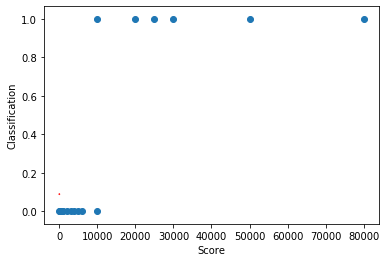

In [165]:
# show the simple model mapped to the training data, algorithm visulization

# plot our original training data
axes = plt.axes()
axes.scatter(x=game_data['Score'], y=game_data['Classification'])

# determine the best fit line
slope = model.coef_[0]
intercept = model.intercept_

# plot the model line
x = np.linspace(10,20)
y = slope*x+intercept
axes.plot(x,y,'r')

# add labels to the graph
axes.set_xlabel('Score')
axes.set_ylabel('Classification')

plt.show()

### Make a prediction

Based on the input score, the model will infer if the score is non-fraudulent or suspiciously high which will kick off a separate investigation workflow.

In [276]:
# make a prediction

score = 40123

# reshape the score into an array
new_score = np.reshape([score],(1,-1))

# Pass the new score to the model so that a predicted classfication can be infered
classification = model.predict(new_score)[0]

# print the information back to the user
if score < 10000:
    print ("If a gamer achieves score %.0f, you can expect it to be classified as %.0f non-fraudulent. No actions required." % (score, classification))
else:
    print ("If a game achieves score %.0f, you can expect it to be classified as %.0f susppiciously high. Need to investigate." % (score, classification))


If a game achieves score 40123, you can expect it to be classified as 1 susppiciously high. Need to investigate.


## Validation, Testing and create model endpoint for real-time response

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [113]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://us-west-2-itsmagic-highscores/capstone/output


In [ ]:
# split the data for training, validation, and test. For the capstone, we'll only do training and omit the validation as test part
rand_split = np.random.rand(len(game_data))

train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.95)
test_list = rand_split >= 0.95

data_train = game_data[train_list]
data_val = game_data[val_list]
data_test = game_data[test_list]

print(data_train)

In [115]:
# algorithm logic to train the data, if the first column data is more than 10000, classify it as 1
train_y = ((data_train.iloc[:,1] > 10000)+1)
train_x = data_train.iloc[:,0]
print(train_y.shape, train_x.shape)


(14,) (14,)


In [116]:
# train_file = "linear_train.data"

# train_file = "mltrainingdatatest3.csv"

# f = io.BytesIO()
# smac.write_numpy_to_dense_tensor(f, train_x.astype('float32'), train_y.astype('float32'))
# f.seek(0)

# s3.Bucket(bucket).Object(prefix + '/train/' + train_file).upload_fileobj(f)

In [117]:
# get EMR container
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name,"linear-learner")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [118]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=784,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-03 18:08:41 Starting - Starting the training job...
2020-08-03 18:08:43 Starting - Launching requested ML instances......
2020-08-03 18:09:54 Starting - Preparing the instances for training.........
2020-08-03 18:11:22 Downloading - Downloading input data...
2020-08-03 18:12:04 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/03/2020 18:12:08 INFO 139838729144128] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'in

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [119]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [135]:
# create a deployable model by identifying the location of model artifacts and the Docker image 
# that contains the inference code.

model_name = 'linear-learner-2020-08-03-18-08-41-073' + '-mod'

# info = sm.describe_training_job(TrainingJobName='linear-learner-2020-08-03-18-08-41-073')
model_data = info['ModelArtifacts']['s3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = 'linear-learner-2020-08-03-18-08-41-073' + '-mod',
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

NameError: name 'info' is not defined

In [ ]:
# Create an Amazon SageMaker endpoint configuration by specifying the ML compute instances 
# that you want to deploy your model to.

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':capstone-test,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

In [ ]:
# Create an Amazon SageMaker endpoint.

%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record.

In [ ]:
# result = linear_predictor.predict(train_set[0][30:31])
# print(result)

OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

In [ ]:
# presuming my algorithm is perfect and no need for evaluation and testing
# import numpy as np

# predictions = []
# for array in np.array_split(test_set[0], 100):
    # result = linear_predictor.predict(array)
    # predictions += [r['predicted_label'] for r in result['predictions']]

# predictions = np.array(predictions)

In [ ]:
# import pandas as pd

# pd.crosstab(np.where(test_set[1] == 0, 1, 0), predictions, rownames=['actuals'], colnames=['predictions'])

As we can see from the confusion matrix above, we predict 931 images of 0 correctly, while we predict 44 images as 0s that aren't, and miss predicting 49 images of 0.

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

# sagemaker.Session().delete_endpoint(linear_predictor.endpoint)